In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render li, div.text_cell_render p, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

<font size="6" color="red"><b>ch4. 머신러닝 모형 최적화</b></font>
# 1절. 변수 선택과 차원 축소
## 1-1 변수선택과 차원축소
- 종속변수에 영향을 주는 변수들을 찾아 학습에 사용할 독립변수의 수를 줄임
 (어떻게 하면 score를 높일 수 있을지?)
- 과적합과 변수들 사이의 다중공선성(변수들간 강한 상관관계)을 줄일 수 있음
 * 회귀계수 해석이 어려워짐. 모델 예측력이 좋아도 해석력이 떨어짐(어떤 변수가 제일 큰 요인인지 잘), p값이
나 유의성 검정이 왜곡될 수 있음
- 모형의 학습 시간을 줄일 수 있음
- 주성분분석, 상관분석, **분류모형의 feature_importance_, 예측 모형의 coef_**
- SelectKBest : 가장 높은 score에 따라 K개의 특징을 선택
## 1-2 주성분분석(PCA, Principal Component Anaysis)
- 주성분분석은 변수 선택 및 차원축소 방법(기존의 모든 변수를 조합하여 새로운 변수로 만듦) 으로 널리 사용
- 주성분 분석은 상관관계가 있는 변수들을 선형결합해서 **분산이 극대화된 상관관계가 없는 새로운 변수(주성분)
들로 축약**하는 것
- 주성분 분석은 사실 선형대수학이라기보다는 선형대수학의 활용적인 측면이 강하며 영상인식, 통계 데이터분석
(주성분 찾기), 데이터 압축, 노이즈제거 등 여러 분야에 사용
- 영상처리에서 많이 활용 : 여러개의 영상 중 대표 이미지를 찾을 때 활용

In [2]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris_X, iris_y = iris.iloc[:, :-1], iris.species
iris_X.shape, iris_y.shape

((150, 4), (150,))

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # n_components : 주성분 갯수
# pca.fit(iris_X)
# pca.transform(iris_X)
iris_pca = pca.fit_transform(iris_X)
iris_pca[:3] # 뽑혀진 주성분 2개

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943]])

In [14]:
import pandas as pd
pd.DataFrame(iris_pca, columns=['pca1', 'pca2']).corr() # 주성분끼리의 상관관계

,pca1,pca2
pca1,1.000000e+00,-3.972182e-17
pca2,-3.972182e-17,1.000000e+00


In [15]:
# 설명분산 : 각 주성분이 데이터 분산을 잘 표현하는지 (정보량). 값이 클수록 더 중요한 주성분
pca.explained_variance_

array([4.22824171, 0.24267075])

In [16]:
# 설명정도 : 0~1사이의 비율로 조정된 값
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

In [17]:
pca.components_
# 각 주성분의 계수 : 각 주성분이 원래 특성들과 어떤 관계가 있는지 나타내는 가중치
# pca1 = 0.36138659*s_length + -0.08452251*s_width + 0.85667061*p_length +0.3582892*p_width
# pca2 = 0.65658877*s_length + ~

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

## 1-3 상관관계 확인
- 각 변수들끼리 상관관계를 확인하고 시각화해서 종속변수와 상관관계가 높은 변수들만 선택

In [22]:
import pandas as pd
# redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine = pd.read_csv('data/winequality-red.csv', delimiter=';')
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


- cmap의 종류 : https://jrc-park.tistory.com/155 
- http://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap 
- http://seaborn.pydata.org/examples/many_pairwise_correlations.html 


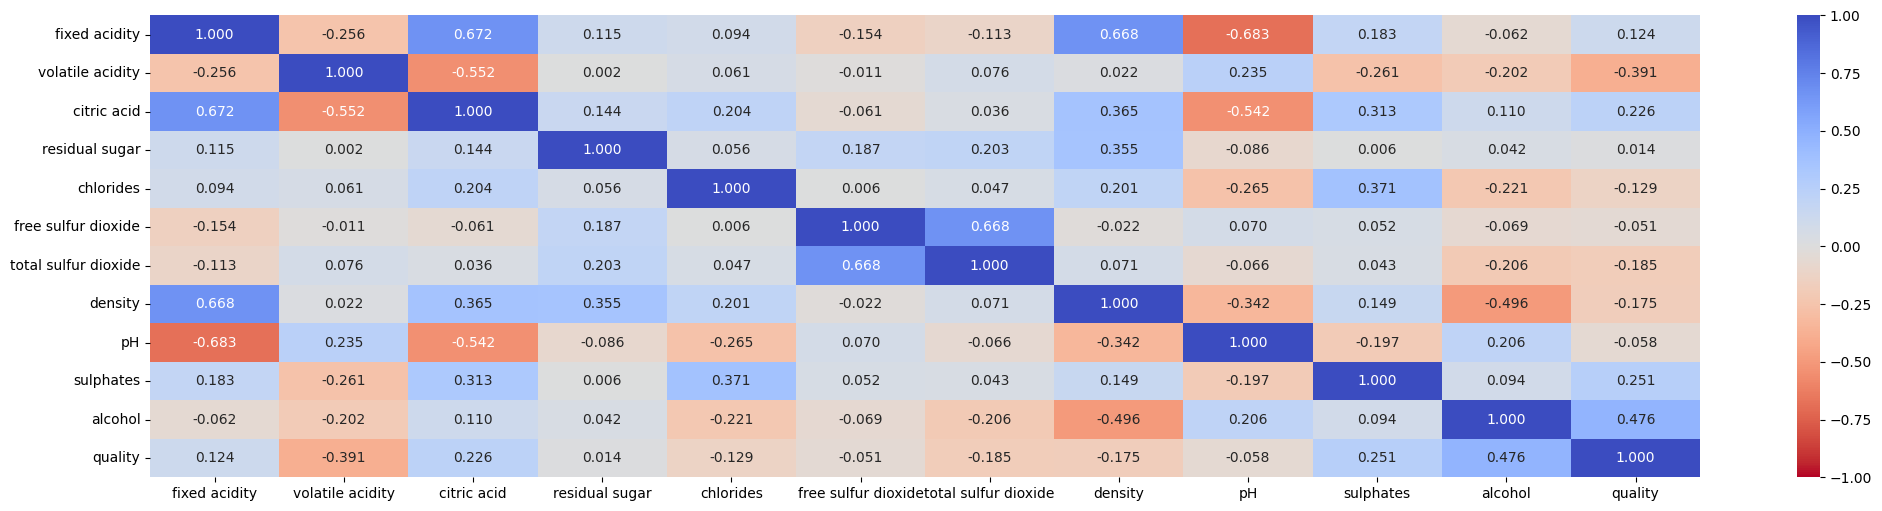

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25,6))
corr = redwine.corr()
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm_r')
plt.show()